# Sampling from a GP

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra

### Generating some random data

In [2]:
kernel = SqExponentialKernel()
x = range(0, 10; length=50)
K = kernelmatrix(kernel, x)
f = rand(MvNormal(K + 1e-8I)) # Sample a random GP
y = rand.(Bernoulli.(AGP.logistic.(f)))
y_sign = Int.(sign.(y .- 0.5))

50-element Vector{Int64}:
 -1
 -1
  1
 -1
 -1
 -1
  1
  1
  1
 -1
  ⋮
  1
 -1
  1
  1
  1
  1
 -1
  1
  1

### We create a function to visualize the data

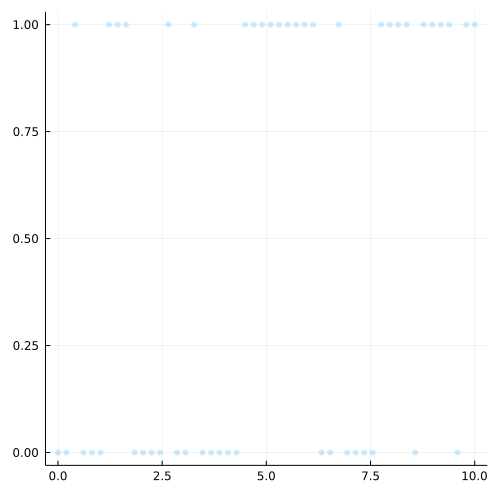

In [3]:
function plot_data(x, y; size=(300, 500))
    return Plots.scatter(x, y; alpha=0.2, markerstrokewidth=0.0, lab="", size=size)
end
plot_data(x, y; size=(500, 500))

### Run the variational gaussian process approximation

In [4]:
@info "Running full model"
mfull = VGP(x, y_sign, kernel, LogisticLikelihood(), AnalyticVI(); optimiser=false)
@time train!(mfull, 5)

[ Info: Running full model
  1.045044 seconds (1.82 M allocations: 103.806 MiB, 8.35% gc time, 99.49% compilation time)


(Variational Gaussian Process with a BernoulliLikelihood{GPLikelihoods.LogisticLink}(GPLikelihoods.LogisticLink(LogExpFunctions.logistic)) infered by Analytic Variational Inference , (local_vars = (c = [0.9215342067738619, 0.8755251220450723, 0.8219423471583542, 0.7677095119507368, 0.7204628675521775, 0.6862673735853088, 0.667390965717379, 0.6636035155533028, 0.6748885077366641, 0.7031320794841993  …  0.782512389333545, 0.9096535665120707, 1.0201290032316552, 1.0981707814491772, 1.1389209601214059, 1.14574336897059, 1.1268298324770671, 1.0926727313044062, 1.0542309302328492, 1.0201090331965206], θ = [0.23369138786323732, 0.23516636334615693, 0.2368152602767665, 0.23840424558922693, 0.2397194127446187, 0.24062934948181644, 0.24111610001870354, 0.24121240969418714, 0.24092410864522076, 0.24018507085232477  …  0.2379787734143374, 0.2340773172922583, 0.23036079380750035, 0.22757590393154462, 0.22607492523013112, 0.22582069797826718, 0.2265234502640415, 0.22777605134294457, 0.22915901912252

### We can also create a sampling based model

In [5]:
@info "Sampling from model"
mmcmc = MCGP(x, y, kernel, LogisticLikelihood(), GibbsSampling(); optimiser=false)
m = mmcmc
@time samples = sample(mmcmc, 1000)

[ Info: Sampling from model
Sampling with Gibbs Sampler   0%|                       |  ETA: N/A
Sampling with Gibbs Sampler   0%|▏                      |  ETA: 0:05:36
Sampling with Gibbs Sampler   1%|▎                      |  ETA: 0:02:51
Sampling with Gibbs Sampler   1%|▍                      |  ETA: 0:01:53
Sampling with Gibbs Sampler   2%|▍                      |  ETA: 0:01:25
Sampling with Gibbs Sampler   2%|▌                      |  ETA: 0:01:08
Sampling with Gibbs Sampler   3%|▋                      |  ETA: 0:00:56
Sampling with Gibbs Sampler   3%|▊                      |  ETA: 0:00:48
Sampling with Gibbs Sampler   4%|▉                      |  ETA: 0:00:42
Sampling with Gibbs Sampler   4%|█                      |  ETA: 0:00:37
Sampling with Gibbs Sampler   5%|█                      |  ETA: 0:00:33
Sampling with Gibbs Sampler   5%|█▏                     |  ETA: 0:00:30
Sampling with Gibbs Sampler   5%|█▎                     |  ETA: 0:00:28
Sampling with Gibbs Sampler   6%|█▍     

1000-element Vector{Vector{Vector{Float64}}}:
 [[-0.5729928625110373, -0.707630174453727, -0.808096011742207, -0.858567761022158, -0.8393651297841901, -0.7867390844415947, -0.7552127442956709, -0.7787806697027836, -0.7782169611031755, -0.8776849475133199  …  0.78439989328712, 0.8846172078146689, 0.92725570985209, 0.9991975588048818, 1.0653275588442022, 1.1186908001019678, 1.1337153064858059, 1.0847352723410282, 0.9624161833039989, 0.7517926553508727]]
 [[0.17092903023353023, 0.10058145503443272, 0.02798592407875472, 0.005061638307820138, -0.07319182672891889, -0.14879964626188785, -0.23248145790231323, -0.32418370913926897, -0.374498565444464, -0.421361839145241  …  1.5890129438682314, 1.5692881665677472, 1.5105509541430806, 1.4732794696892113, 1.4312155865102896, 1.4136867275271614, 1.3944147560686728, 1.352487598341338, 1.2481796344282596, 1.092833389443351]]
 [[-0.9083247977739886, -0.7040522693601539, -0.48903786662666116, -0.2557443828754654, -0.049042439604124966, 0.1010048675219

### We can now visualize the results of both models

### We first plot the latent function f (truth, the VI estimate, the samples)

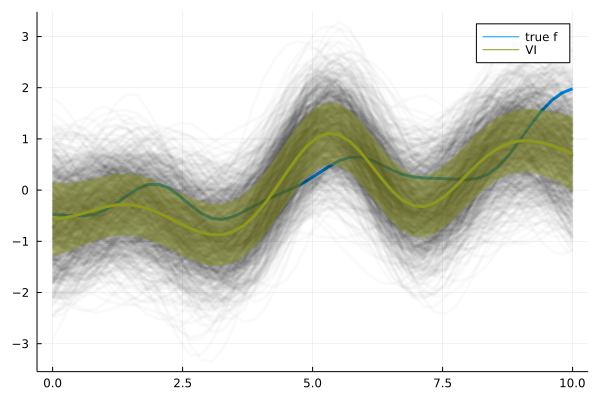

In [6]:
p1 = plot(x, f; label="true f")
plot!(x, samples; label="", color=:black, alpha=0.02, lab="")
plot!(x, mean(mfull[1]); ribbon=sqrt.(var(mfull[1])), label="VI")

### And we can also plot the predictions vs the data

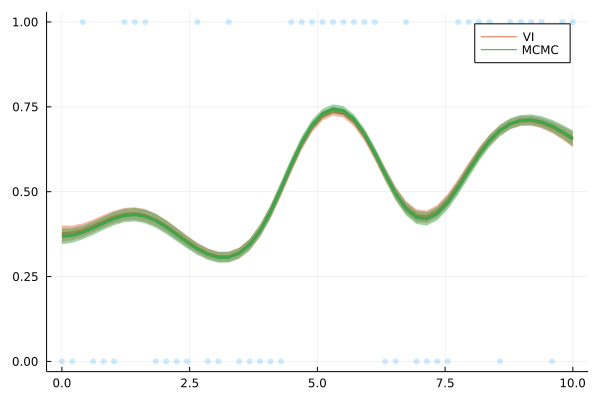

In [7]:
p2 = plot_data(x, y; size=(600, 400))
μ_vi, σ_vi = proba_y(mfull, x)
plot!(x, μ_vi; ribbon=σ_vi, label="VI")
μ_mcmc, σ_mcmc = proba_y(mmcmc, x)
plot!(x, μ_mcmc; ribbon=σ_mcmc, label="MCMC")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*